In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import numpy.random
#import tensorflow as tf
import pandas as pd

import sklearn.linear_model
#import sklearn.svm
import sklearn.model_selection
import sklearn.metrics
import sklearn.preprocessing

import scipy.stats

from IPython.display import display
import datetime
import struct
import time

root_dir = "D:/Jupyter/";
logs_dir = root_dir + "Logs/"
data_dir = root_dir + 'Datasets/'

In [2]:
src = pd.read_csv(data_dir + 'SBRF/train.csv')
src['log_price'] = np.log(src.price_doc)

## Target variable distribution

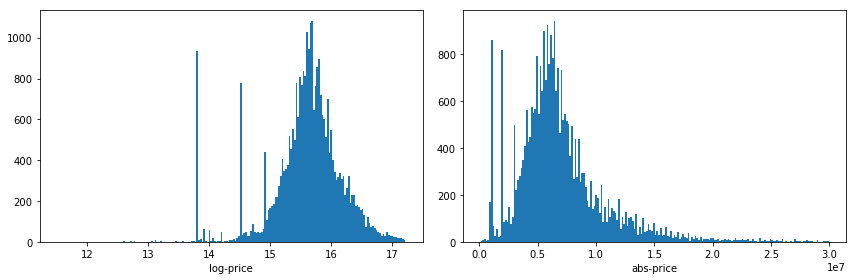

In [3]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist(src.log_price[src.price_doc<30000000], bins=200)
plt.xlabel('log-price')
plt.subplot(1,2,2)
plt.hist(src.price_doc[src.price_doc<30000000], bins=200)
plt.xlabel('abs-price')
plt.tight_layout()
plt.show()

#### Conclusion
1. Strong convergence to round numbers
2. Good distribution in log scale
3. A few outliers

## Filtering, outlier and missing value detection

In [4]:
def qfilter_dataset(ds, var, pct_range=(5, 95)):
    return ds[(ds[var] > np.nanpercentile(ds[var], pct_range[0])) & (ds[var] < np.nanpercentile(ds[var], pct_range[1]))]

def qfilter_dataset_decompose(ds, var, pct_range=(5,95)):
    nan_mask = np.isnan(ds[var])
    high_mask = ds[var] > np.nanpercentile(ds[var], pct_range[0])
    low_mask = ds[var] < np.nanpercentile(ds[var], pct_range[1])
    return (ds[high_mask & low_mask], ds[~(high_mask | nan_mask)], ds[~(low_mask | nan_mask)], ds[nan_mask])

In [ ]:
#Example
qfilter_dataset_decompose(src, 'life_sq')[3].describe()

## Correlation matrix
We are using kendall-tau to not lose nonlinear dependency

### Correlation with target variable

In [5]:
def correl_varstat(ds, y, x):
    cor = scipy.stats.kendalltau(ds[y], ds[x])[0]
    num = len(ds)
    ymean = np.mean(ds[y])
    xmean = np.mean(ds[x])
    return (cor, {'num':num,'ymean':ymean, 'xmean':xmean,'cor':cor})

target_correlation = []
for var in src.columns:
    if src.dtypes[var] not in ('int64', 'float64') or var in ('id', 'price_doc', 'log_price'):
        continue
    ds_mid, ds_low, ds_high, ds_nan = qfilter_dataset_decompose(src, var, (1, 99))
    target_correlation += [[var] + [correl_varstat(x, 'price_doc', var)[1] for x in [ds_low, ds_mid, ds_high, ds_nan]]]

In [6]:
datatable = [[x[0], x[2]['cor'], x[2]['num'], x[1]['ymean']/1000000, x[3]['ymean']/1000000] for x in target_correlation]
stats_ds = pd.DataFrame([x[1:] for x in datatable], index=[x[0] for x in datatable],columns=['cor', 'num', 'mean-lo', 'mean-hi'])
stats_ds = stats_ds.dropna().sort_values(by='cor', ascending=False)
display(stats_ds[:5])
display(stats_ds[-5:])

,cor,num,mean-lo,mean-hi
full_sq,0.357658,29763,3.734499,22.702617
life_sq,0.302390,23406,7.022817,19.961248
num_room,0.298574,12807,5.335340,18.519213
cafe_count_2000,0.270345,28318,4.730609,6.002346
cafe_count_3000,0.266799,29157,4.190928,5.842008


,cor,num,mean-lo,mean-hi
zd_vokzaly_avto_km,-0.210967,29861,10.838438,3.841051
sadovoe_km,-0.212454,29857,15.215929,4.049223
ttk_km,-0.221225,29861,9.038323,4.171795
bulvar_ring_km,-0.233651,29500,7.119439,4.021978
kremlin_km,-0.239098,29562,5.842008,3.994520


In [11]:
def gauss_smooth(ds, y, x, xs, sigma=1):
    tx0 = np.array(xs).reshape(len(xs))
    tx = np.array(ds[x]).reshape(len(ds[x]), 1)
    ty = np.array(ds[y]).reshape(1, len(ds[y]))
    tw = scipy.stats.norm.pdf((tx - tx0.reshape(1, len(tx0))) / sigma)
    return (np.matmul(ty, tw) / np.sum(tw, axis=0)).reshape(xs.shape)

def plot_smoothed(ds, x, y, num_points=100, sigma=1, plot_args={}, xlim=(-np.inf, np.inf)):
    xmin = max(xlim[0], np.min(ds[x]))
    xmax = min(xlim[1], np.max(ds[x]))
    xs = np.linspace(xmin, xmax, num_points)
    ys = gauss_smooth(ds, y, x, xs, sigma=sigma)
    plt.plot(xs, ys, **plot_args)

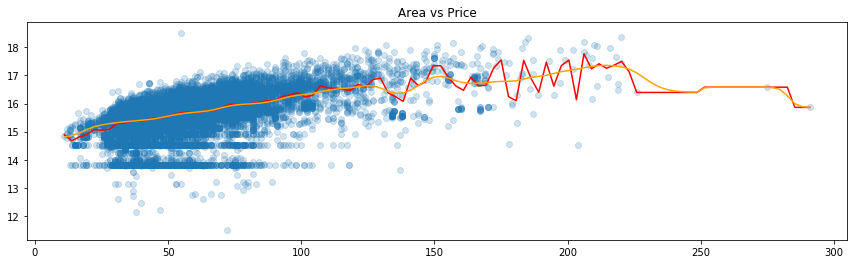

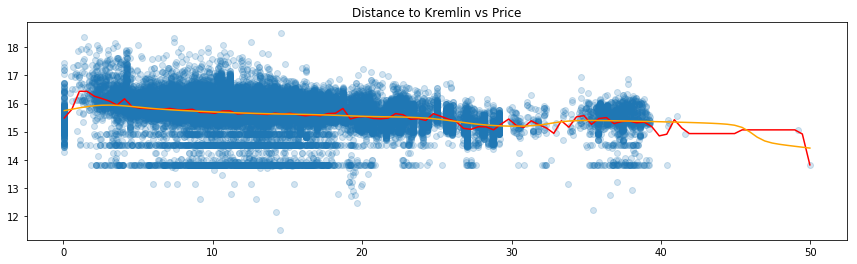

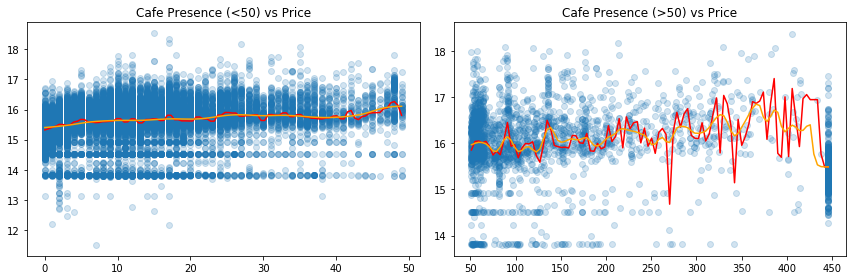

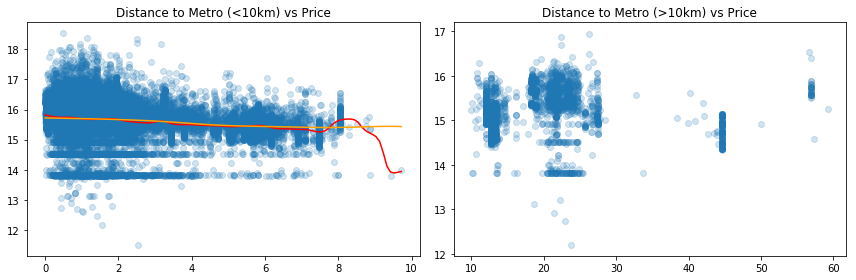

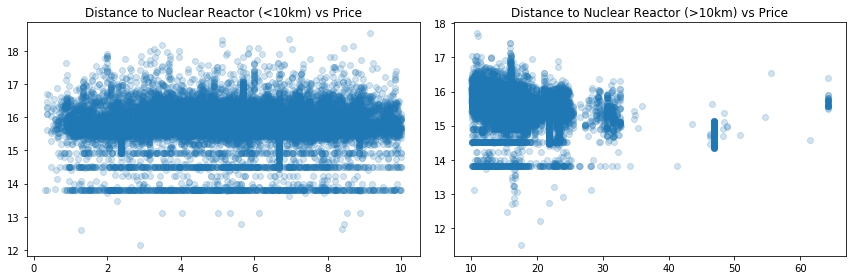

In [17]:
tmp = src[(src.full_sq < 300) & (src.full_sq > 10)]
plt.figure(figsize=(14.7,4))
plt.scatter(tmp.full_sq, tmp.log_price, alpha=0.2)
plot_smoothed(tmp, 'full_sq', 'log_price', sigma=1, plot_args={'color': 'red'})
plot_smoothed(tmp, 'full_sq', 'log_price', sigma=5, plot_args={'color': 'orange'})
plt.title('Area vs Price')
plt.show()

tmp = src[src.kremlin_km<50]
plt.figure(figsize=(14.7,4))
plt.scatter(tmp.kremlin_km, tmp.log_price, alpha=0.2)
plot_smoothed(tmp, 'kremlin_km', 'log_price', sigma=0.2, plot_args={'color': 'red'})
plot_smoothed(tmp, 'kremlin_km', 'log_price', sigma=2, plot_args={'color': 'orange'})
plt.title('Distance to Kremlin vs Price')
plt.show()


tmp1 = src[(src.cafe_count_3000_price_1500 < 50)]
tmp2 = src[(src.cafe_count_3000_price_1500 > 50)]
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.scatter(tmp1.cafe_count_3000_price_1500, tmp1.log_price, alpha=0.2)
plot_smoothed(tmp1, 'cafe_count_3000_price_1500', 'log_price', sigma=0.2, plot_args={'color': 'red'})
plot_smoothed(tmp1, 'cafe_count_3000_price_1500', 'log_price', sigma=2, plot_args={'color': 'orange'})
plt.title('Cafe Presence (<50) vs Price')
plt.subplot(1,2,2)
plt.scatter(tmp2.cafe_count_3000_price_1500, tmp2.log_price, alpha=0.2)
plot_smoothed(tmp2, 'cafe_count_3000_price_1500', 'log_price', sigma=1, plot_args={'color': 'red'})
plot_smoothed(tmp2, 'cafe_count_3000_price_1500', 'log_price', sigma=5, plot_args={'color': 'orange'})
plt.title('Cafe Presence (>50) vs Price')
plt.tight_layout()
plt.show()

tmp1 = src[(src.metro_km_walk < 10)]
tmp2 = src[(src.metro_km_walk > 10)]
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.scatter(tmp1.metro_km_walk, tmp1.log_price, alpha=0.2)
plot_smoothed(tmp1, 'metro_km_walk', 'log_price', sigma=0.2, plot_args={'color': 'red'})
plot_smoothed(tmp1, 'metro_km_walk', 'log_price', sigma=1, plot_args={'color': 'orange'})
plt.title('Distance to Metro (<10km) vs Price')
plt.subplot(1,2,2)
plt.scatter(tmp2.metro_km_walk, tmp2.log_price, alpha=0.2)
plt.title('Distance to Metro (>10km) vs Price')
plt.tight_layout()
plt.show()


tmp1 = src[(src.nuclear_reactor_km < 10)]
tmp2 = src[(src.nuclear_reactor_km > 10)]
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.scatter(tmp1.nuclear_reactor_km, tmp1.log_price, alpha=0.2)
plt.title('Distance to Nuclear Reactor (<10km) vs Price')
plt.subplot(1,2,2)
plt.scatter(tmp2.nuclear_reactor_km, tmp2.log_price, alpha=0.2)
plt.title('Distance to Nuclear Reactor (>10km) vs Price')
plt.tight_layout()
plt.show()

#### Conclusion
1. Nuclear Reactor distance does not seem to correlate at all
2. Distance to Metro works in very strange fashion:
    1. Small distances (<2km) provide high variance
    2. Medium distances (2-10km) provide small variance
    3. Large distances identify certain clusters, which probably should be investigated
3. Distance to Kremlin provides good correlation and also spots some clusters
4. Area is definitely a great

#### Next Steps
1. Fit simplest model with: area, distance to kremlin and distance to metro
2. Validate on all clusters and on this variables
3. Search additional dependencies (if no strong dependencies left, move to serious ML)

In [35]:
tmp = src[(src.full_sq < 300) & (src.full_sq > 10)]
lr_full_sq = sklearn.linear_model.LinearRegression().fit(tmp.full_sq.values.reshape(-1,1), tmp.log_price.values.reshape(-1,1))
src['log_price_resid'] = src.log_price.values.reshape(-1,1) - lr_full_sq.predict(src.full_sq.values.reshape(-1,1))

In [40]:
target_resid_correlation = []
for var in src.columns:
    if src.dtypes[var] not in ('int64', 'float64') or var in ('id', 'price_doc', 'log_price', 'log_price_resid'):
        continue
    ds_mid, ds_low, ds_high, ds_nan = qfilter_dataset_decompose(src, var, (25, 75))
    target_resid_correlation += [[var] + [correl_varstat(x, 'log_price_resid', var)[1] for x in [ds_low, ds_mid, ds_high, ds_nan]]]
datatable = [[x[0], x[2]['cor'], x[2]['num'], x[1]['ymean']/1000000, x[3]['ymean']/1000000] for x in target_resid_correlation]
stats_resid_ds = pd.DataFrame([x[1:] for x in datatable], index=[x[0] for x in datatable],columns=['cor', 'num', 'mean-lo', 'mean-hi'])
stats_resid_ds = stats_resid_ds.dropna().sort_values(by='cor', ascending=False)
display(stats_resid_ds[:5])
display(stats_resid_ds[-5:])

,cor,num,mean-lo,mean-hi
office_count_3000,0.248744,15154,-2.106315e-07,1.730616e-07
build_count_wood,0.239999,5771,5.165032e-08,1.668829e-09
office_count_2000,0.239504,12815,-1.738040e-07,1.611031e-07
office_sqm_5000,0.230834,15189,-2.180264e-07,1.914176e-07
cafe_count_5000_na_price,0.224720,14424,-2.261005e-07,1.646250e-07


,cor,num,mean-lo,mean-hi
ttk_km,-0.209647,15173,1.727000e-07,-2.367856e-07
kremlin_km,-0.212775,15178,1.755405e-07,-2.372678e-07
stadium_km,-0.241151,15057,1.187916e-07,-2.067109e-07
ID_big_road1,-0.295601,12348,2.808164e-08,-1.743397e-08
ID_bus_terminal,-0.324599,14206,5.698424e-08,-5.042535e-08


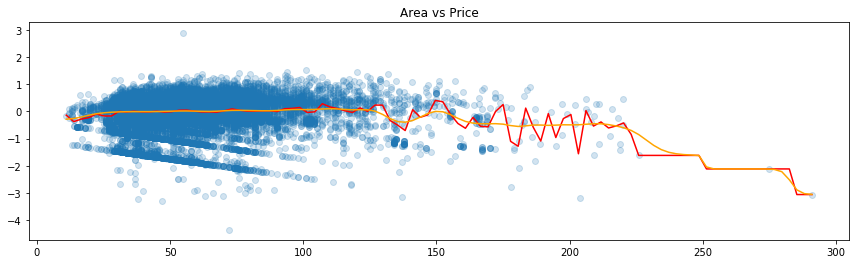

C:\Anaconda3\lib\site-packages\numpy\core\function_base.py:128: RuntimeWarning: invalid value encountered in multiply
  y = y * step
C:\Anaconda3\lib\site-packages\numpy\core\function_base.py:135: RuntimeWarning: invalid value encountered in add
  y += start
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: RuntimeWarning: invalid value encountered in true_divide


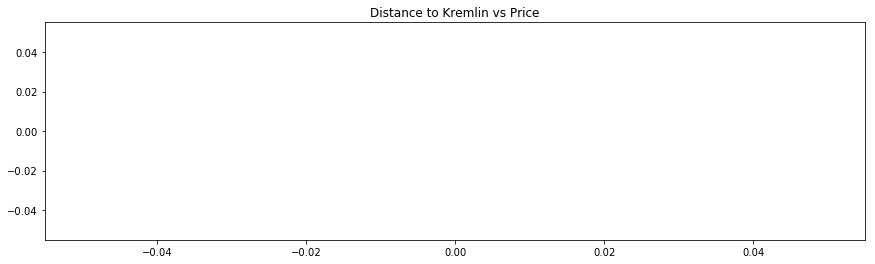

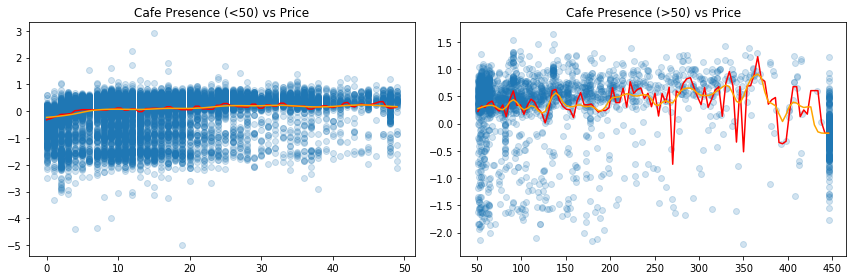

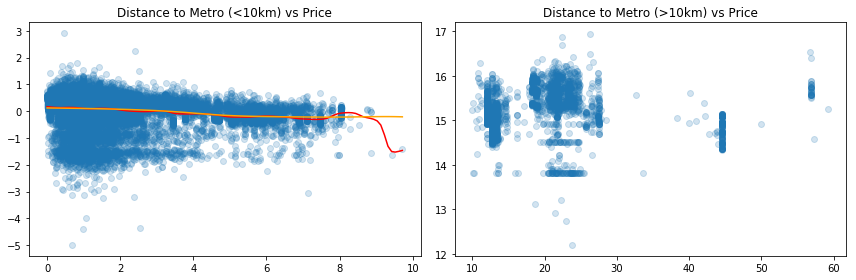

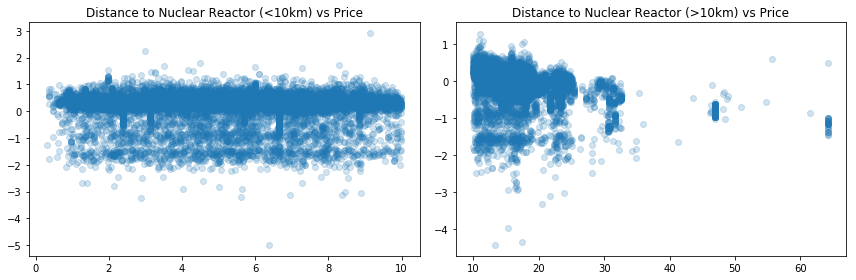

In [37]:
tmp = src[(src.full_sq < 300) & (src.full_sq > 10)]
plt.figure(figsize=(14.7,4))
plt.scatter(tmp.full_sq, tmp.log_price_resid, alpha=0.2)
plot_smoothed(tmp, 'full_sq', 'log_price_resid', sigma=1, plot_args={'color': 'red'})
plot_smoothed(tmp, 'full_sq', 'log_price_resid', sigma=5, plot_args={'color': 'orange'})
plt.title('Area vs Price')
plt.show()

tmp = src[src.kremlin_km<50 & (np.abs(src.log_price_resid) < 5)]
plt.figure(figsize=(14.7,4))
plt.scatter(tmp.kremlin_km, tmp.log_price_resid, alpha=0.2)
plot_smoothed(tmp, 'kremlin_km', 'log_price_resid', sigma=0.2, plot_args={'color': 'red'})
plot_smoothed(tmp, 'kremlin_km', 'log_price_resid', sigma=2, plot_args={'color': 'orange'})
plt.title('Distance to Kremlin vs Price')
plt.show()


tmp1 = src[(src.cafe_count_3000_price_1500 < 50) & (np.abs(src.log_price_resid) < 5)]
tmp2 = src[(src.cafe_count_3000_price_1500 > 50) & (np.abs(src.log_price_resid) < 5)]
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.scatter(tmp1.cafe_count_3000_price_1500, tmp1.log_price_resid, alpha=0.2)
plot_smoothed(tmp1, 'cafe_count_3000_price_1500', 'log_price_resid', sigma=0.2, plot_args={'color': 'red'})
plot_smoothed(tmp1, 'cafe_count_3000_price_1500', 'log_price_resid', sigma=2, plot_args={'color': 'orange'})
plt.title('Cafe Presence (<50) vs Price')
plt.subplot(1,2,2)
plt.scatter(tmp2.cafe_count_3000_price_1500, tmp2.log_price_resid, alpha=0.2)
plot_smoothed(tmp2, 'cafe_count_3000_price_1500', 'log_price_resid', sigma=1, plot_args={'color': 'red'})
plot_smoothed(tmp2, 'cafe_count_3000_price_1500', 'log_price_resid', sigma=5, plot_args={'color': 'orange'})
plt.title('Cafe Presence (>50) vs Price')
plt.tight_layout()
plt.show()

tmp1 = src[(src.metro_km_walk < 10) & (np.abs(src.log_price_resid) < 5)]
tmp2 = src[(src.metro_km_walk > 10) & (np.abs(src.log_price_resid) < 5)]
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.scatter(tmp1.metro_km_walk, tmp1.log_price_resid, alpha=0.2)
plot_smoothed(tmp1, 'metro_km_walk', 'log_price_resid', sigma=0.2, plot_args={'color': 'red'})
plot_smoothed(tmp1, 'metro_km_walk', 'log_price_resid', sigma=1, plot_args={'color': 'orange'})
plt.title('Distance to Metro (<10km) vs Price')
plt.subplot(1,2,2)
plt.scatter(tmp2.metro_km_walk, tmp2.log_price, alpha=0.2)
plt.title('Distance to Metro (>10km) vs Price')
plt.tight_layout()
plt.show()


tmp1 = src[(src.nuclear_reactor_km < 10) & (np.abs(src.log_price_resid) < 5)]
tmp2 = src[(src.nuclear_reactor_km > 10) & (np.abs(src.log_price_resid) < 5)]
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.scatter(tmp1.nuclear_reactor_km, tmp1.log_price_resid, alpha=0.2)
plt.title('Distance to Nuclear Reactor (<10km) vs Price')
plt.subplot(1,2,2)
plt.scatter(tmp2.nuclear_reactor_km, tmp2.log_price_resid, alpha=0.2)
plt.title('Distance to Nuclear Reactor (>10km) vs Price')
plt.tight_layout()
plt.show()